In [2]:
%matplotlib inline


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [5]:
# -- TODO
from models import get_model

experiments_path = "experiments/"
data_dir = 'datasets/'


def save_model(model, acc, data_transforms, folder, file_name, other_info=dict()):
    save_data = {
        "state_dict": model.state_dict(),
        "data_transforms": data_transforms,
        "acc": acc,
        "model_name": model_name,
    }
    save_data.update(other_info)
    
    torch.save(save_data, os.path.join(folder, f"checkpoint_{file_name}"))


def new_save_folder(exp_name):
    save_f = os.path.join(experiments_path, f"{int(time.time())}_{exp_name}")
    os.mkdir(save_f)
    return save_f

    
model_name = "alexnet"

in_size = torch.Size([3, 224, 224])
out_size = None  # Calculate after loading data
best_eval_acc = 0

# Create experiment folder
save_best = True
save_all = False

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
out_size = torch.Size([len(class_names)])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



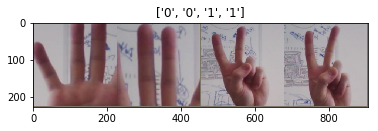

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [8]:
def train_model(model, criterion, optimizer, scheduler, save_folder, other_info, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                if save_best:
                    save_model(model, epoch_acc, data_transforms, save_folder, "best", other_info)
            
            if save_all:
                save_model(model, epoch_acc, data_transforms, save_folder, str(epoch), other_info)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [10]:
model_ft = get_model(model_name, in_size=in_size, out_size=out_size, pretrained=True)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Not loading layer: classifier.6.weight
Not loading layer: classifier.6.bias


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [11]:
save_folder = new_save_folder("summer_full_train")
other_info = {"in_size": in_size, "out_size": out_size, "model_name": model_name}
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, save_folder, other_info,
                       num_epochs=5)

Epoch 0/4
----------


train Loss: 0.2021 Acc: 0.9072


val Loss: 0.0000 Acc: 1.0000



Epoch 1/4
----------


train Loss: 0.0739 Acc: 0.9667


val Loss: 0.0000 Acc: 1.0000

Epoch 2/4
----------


train Loss: 0.0530 Acc: 0.9772


val Loss: 0.0003 Acc: 1.0000

Epoch 3/4
----------


train Loss: 0.0698 Acc: 0.9685


val Loss: 0.0000 Acc: 1.0000

Epoch 4/4
----------


train Loss: 0.0288 Acc: 0.9877


val Loss: 0.0000 Acc: 1.0000

Training complete in 1m 12s
Best val Acc: 1.000000


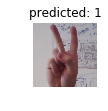

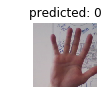

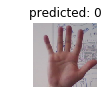

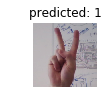

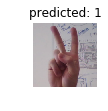

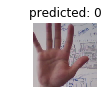

In [11]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [14]:
model_conv = get_model(model_name, in_size=in_size, out_size=out_size, pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Custom for alexnet 
num_ftrs = model_conv.classifier[-1].in_features
model_conv.classifier[-1] = nn.Linear(num_ftrs, out_size[0])

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier[-1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Not loading layer: classifier.6.weight
Not loading layer: classifier.6.bias


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [16]:
save_folder = new_save_folder("summer_fine_tune")
other_info = {"in_size": in_size, "out_size": out_size, "model_name": model_name}
model_conv = train_model(model_conv, criterion, optimizer_conv, 
                         exp_lr_scheduler, save_folder, other_info, num_epochs=25)

Epoch 0/24
----------


train Loss: 0.2846 Acc: 0.8879


val Loss: 0.0005 Acc: 1.0000



Epoch 1/24
----------


train Loss: 0.0639 Acc: 0.9737


val Loss: 0.0000 Acc: 1.0000

Epoch 2/24
----------


train Loss: 0.0480 Acc: 0.9860


val Loss: 0.0335 Acc: 0.9790

Epoch 3/24
----------


train Loss: 0.1364 Acc: 0.9580


val Loss: 0.0000 Acc: 1.0000

Epoch 4/24
----------


train Loss: 0.1776 Acc: 0.9492


val Loss: 0.0063 Acc: 1.0000

Epoch 5/24
----------


train Loss: 0.1581 Acc: 0.9632


val Loss: 0.0000 Acc: 1.0000

Epoch 6/24
----------


train Loss: 0.0725 Acc: 0.9790


val Loss: 0.0000 Acc: 1.0000

Epoch 7/24
----------


train Loss: 0.1436 Acc: 0.9580


val Loss: 0.0000 Acc: 1.0000

Epoch 8/24
----------


train Loss: 0.0727 Acc: 0.9807


val Loss: 0.0000 Acc: 1.0000

Epoch 9/24
----------


train Loss: 0.0622 Acc: 0.9790


val Loss: 0.0000 Acc: 1.0000

Epoch 10/24
----------


train Loss: 0.1208 Acc: 0.9737


val Loss: 0.0000 Acc: 1.0000

Epoch 11/24
----------


train Loss: 0.1002 Acc: 0.9720


val Loss: 0.0000 Acc: 1.0000

Epoch 12/24
----------


train Loss: 0.0780 Acc: 0.9755


val Loss: 0.0000 Acc: 1.0000

Epoch 13/24
----------


train Loss: 0.0916 Acc: 0.9650


val Loss: 0.0000 Acc: 1.0000

Epoch 14/24
----------


train Loss: 0.0600 Acc: 0.9825


val Loss: 0.0000 Acc: 1.0000

Epoch 15/24
----------


train Loss: 0.0818 Acc: 0.9825


val Loss: 0.0000 Acc: 1.0000

Epoch 16/24
----------


train Loss: 0.0626 Acc: 0.9825


val Loss: 0.0000 Acc: 1.0000

Epoch 17/24
----------


train Loss: 0.0668 Acc: 0.9790


val Loss: 0.0000 Acc: 1.0000

Epoch 18/24
----------


train Loss: 0.0635 Acc: 0.9860


val Loss: 0.0000 Acc: 1.0000

Epoch 19/24
----------


train Loss: 0.0636 Acc: 0.9825


val Loss: 0.0000 Acc: 1.0000

Epoch 20/24
----------


train Loss: 0.0561 Acc: 0.9790


val Loss: 0.0000 Acc: 1.0000

Epoch 21/24
----------


train Loss: 0.0644 Acc: 0.9825


val Loss: 0.0000 Acc: 1.0000

Epoch 22/24
----------


train Loss: 0.0629 Acc: 0.9790


val Loss: 0.0000 Acc: 1.0000

Epoch 23/24
----------


train Loss: 0.0542 Acc: 0.9807


val Loss: 0.0000 Acc: 1.0000

Epoch 24/24
----------


train Loss: 0.0861 Acc: 0.9737


val Loss: 0.0000 Acc: 1.0000

Training complete in 1m 48s
Best val Acc: 1.000000


In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()